In [21]:
import sys
import os

# Add src to the system path to allow imports from the src directory
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../../..', 'src'))
sys.path.insert(0, src_path)

In [29]:
from dolfin import *
import ufl
from materials import *
from params import *
from matplotlib import pyplot as plt
from problems import *

%matplotlib inline
set_log_level(50)  # Set log level to suppress unnecessary output

## Initialize problem

In [30]:
params = Params()
params.print_table()

| Parameter    |        Value | Unit   |
|--------------|--------------|--------|
| dimension    |      3       | -      |
| plane_stress |      0       | Bool   |
| Lx           |    500       | m      |
| Ly           |    750       | m      |
| Lz           |    125       | m      |
| g            |      9.81    | m/s²   |
| rho_sea      |  10006.2     | N/m³   |
| E0_ice       |      9.5e+09 | Pa     |
| nu_ice       |      0.35    | -      |
| rho_i_ice    |   8995.77    | N/m³   |
| sigma_c_ice  | 474000       | Pa     |
| ci           |      1       | -      |
| l            |      0.625   | m      |


In [31]:
g = params.g
rho_sea = params.rho_sea
E0_ice = params.E0_ice
nu_ice = params.nu_ice
rho_i_ice = params.rho_i_ice
sigma_c_ice = params.sigma_c_ice
l = params.l

In [32]:
xdmf = XDMFFile("output/static/single_crevasse_2D_fracture.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = False
xdmf.parameters["flush_output"] = True

## Initialize Mesh

0.11523524312479005

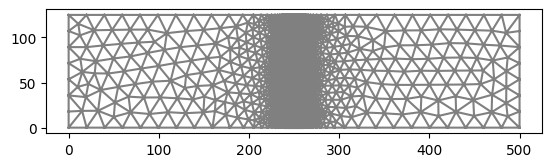

In [33]:
Lx, Ly, Lz = params.Lx, params.Ly, params.Lz
mesh = Mesh()
with XDMFFile("mesh/single_crevasse/ice.xdmf") as infile:
    infile.read(mesh)
plot(mesh)
mesh.hmin()

## Initialize material model

In [34]:
ice = LinearElastic(mesh, params)

# Initialize boundary conditions

In [35]:
FDG0 = FunctionSpace(mesh, "DG", 0)
TDG0 = TensorFunctionSpace(mesh, "DG", 0)
V1 = VectorFunctionSpace(mesh, "CG", 1)
F1 = FunctionSpace(mesh, "CG", 1)


In [36]:
support_left = CompiledSubDomain("on_boundary && near(x[0], 0.0, tol)", tol=1e-14)
support_bottom = CompiledSubDomain("on_boundary && near(x[1],0.0, tol)", tol=1e-14)
load_right = CompiledSubDomain("on_boundary && x[1]<= 62.5 && x[0]==500")

mf_line = MeshFunction("size_t", mesh, 1)
load_right.mark(mf_line, 1)

ds = Measure("ds")(subdomain_data=mf_line)

In [37]:
bc_sp_x = DirichletBC(V1.sub(0), Constant(0.0), support_left)
bc_sp_x2 = DirichletBC(V1.sub(1), Constant(0.0), support_bottom)
bc_u = [bc_sp_x, bc_sp_x2]

## Setup and Solve Problem

In [38]:
u, v = TrialFunction(V1), TestFunction(V1)
unew, uold = Function(V1, name="disp"), Function(V1, name="disp")

cdf_new, cdf_old = Function(FDG0, name="cdf"), Function(FDG0, name="cdf")
stress_xx, cdf = Function(FDG0, name="sigma_xx"), Function(FDG0, name="cdf")

In [39]:
p, q = TrialFunction(F1), TestFunction(F1)
pnew, pold = Function(F1, name="damage"), Function(F1, name="damage")

In [40]:
# t = Expression(("-(rho_sea*(125/2 -x[1]))", 0), rho_sea=rho_sea, degree=1)

t = Constant((0, 0))
f = Constant((0, -ice.rho))

In [41]:
a_disp = inner(((1 - pold) ** 2 + 1e-4) * ice.stress(u), ice.strain(v)) * dx
step_fun = conditional(gt(pold, 0.001), 0.0, 1.0)
L_disp = step_fun * dot(f, v) * dx + dot(t, v) * ds(1)
a_phase = ((1 + cdf_new) * inner(p, q) + l**2 * inner(grad(p), grad(q))) * dx
L_phase = inner(cdf_new, q) * dx

disp_problem = LinearVariationalProblem(a_disp, L_disp, unew, bc_u)
phase_problem = LinearVariationalProblem(a_phase, L_phase, pnew)
problem = FractureProblem(disp_problem, phase_problem, ice, cdf_new, cdf_old)
solver = FractureSolver(problem)
prm = solver.parameters
prm["time_start"] = 0.0
prm["time_total"] = 100.0
prm["delta_t"] = 1.0
prm["multi_staggered"]["tolerance"] = 1e-5
prm["multi_staggered"]["maximum_iterations"] = 1
solver.solve()


step:   0.0, dof:    377418, hmin:  0.12 time:      2
step:   1.0, dof:    377418, hmin:  0.12 time:      4
step:   2.0, dof:    377418, hmin:  0.12 time:      5
step:   3.0, dof:    377418, hmin:  0.12 time:      7
step:   4.0, dof:    377418, hmin:  0.12 time:      9
step:   5.0, dof:    377418, hmin:  0.12 time:     11
step:   6.0, dof:    377418, hmin:  0.12 time:     12
step:   7.0, dof:    377418, hmin:  0.12 time:     14
step:   8.0, dof:    377418, hmin:  0.12 time:     16
step:   9.0, dof:    377418, hmin:  0.12 time:     18
step:  10.0, dof:    377418, hmin:  0.12 time:     19
step:  11.0, dof:    377418, hmin:  0.12 time:     21
step:  12.0, dof:    377418, hmin:  0.12 time:     22
step:  13.0, dof:    377418, hmin:  0.12 time:     24
step:  14.0, dof:    377418, hmin:  0.12 time:     26
step:  15.0, dof:    377418, hmin:  0.12 time:     27
step:  16.0, dof:    377418, hmin:  0.12 time:     29
step:  17.0, dof:    377418, hmin:  0.12 time:     31
step:  18.0, dof:    377418,

## Post Processing

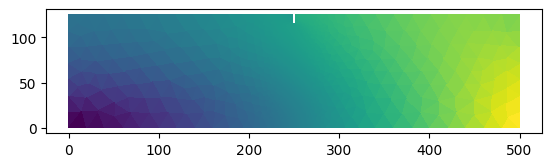

In [16]:
plot(unew, mode='displacement')

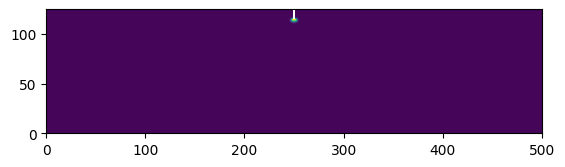

In [20]:
plot(pnew)